In [1]:
#If connector is not installed yet
#!pip install neo4j-driver
#!pip install neo4jupyter

In [2]:
#Imports
from neo4j import GraphDatabase, basic_auth
import neo4jupyter
import pandas as pd
from vis_class import vis_class

In [3]:
#Create db connector
login = open("Login.txt", "r")
uri = login.readline().strip()
user = login.readline().strip()
password = login.readline().strip()
login.close()

driver = GraphDatabase.driver(uri, auth=basic_auth(user, password))
session = driver.session(database="neo4j")
visualizer = vis_class()

neo4j+s://64a10ea6.databases.neo4j.io:7687
neo4j
ZZVmLzBhT0PfX1uvfgXTK2aU2QRjI3WYo2ziOciVAAs


<IPython.core.display.Javascript object>

Vis class was created


# Setup the database

This notebook is for the set up of the database and getting the data into it.

In [4]:
#Reset database
delete_nodes_with_relationship = "match (a) -[r] -> () delete a, r"
delete_nodes_without_relationships = "match (a) delete a"
# All indexes and constraints.
delete_all_index = "CALL apoc.schema.assert({},{},true) YIELD label, key RETURN *"

session.run(delete_nodes_with_relationship)
session.run(delete_nodes_without_relationships)
session.run(delete_all_index)

In [5]:
#Load nodes and relations from file
nodes_relation_open = open("nodes_relations.txt", "r")
nodes_relations = nodes_relation_open.read()
nodes_relation_open.close()
print(nodes_relations[:195])

CREATE
  (Episode1:Movie {name: 'Episode I: The Phantom Menace'}),
  (Episode2:Movie {name: 'Episode II: Attack of the Clones'}),
  (Episode3:Movie {name: 'Episode III: Revenge of the Sith'}),
  


In [6]:
#Filldatabase with nodes and relationships
session.run(nodes_relations)

# Get the first informations from the database

In [7]:
#Get the graph structure
results = session.read_transaction(
    lambda tx: tx.run("CALL db.schema.visualization()").data())
dic = {"Movie": "title", "Person": "name"}
results

[{'nodes': [{'name': 'Movie', 'indexes': [], 'constraints': []},
   {'name': 'Person', 'indexes': [], 'constraints': []},
   {'name': 'Droid', 'indexes': [], 'constraints': []}],
  'relationships': [({'name': 'Droid', 'indexes': [], 'constraints': []},
    'SPEAKS_WITH',
    {'name': 'Droid', 'indexes': [], 'constraints': []}),
   ({'name': 'Person', 'indexes': [], 'constraints': []},
    'SPEAKS_WITH',
    {'name': 'Droid', 'indexes': [], 'constraints': []}),
   ({'name': 'Person', 'indexes': [], 'constraints': []},
    'SPEAKS_WITH',
    {'name': 'Person', 'indexes': [], 'constraints': []}),
   ({'name': 'Droid', 'indexes': [], 'constraints': []},
    'SPEAKS_WITH',
    {'name': 'Person', 'indexes': [], 'constraints': []}),
   ({'name': 'Droid', 'indexes': [], 'constraints': []},
    'APPEARS_IN',
    {'name': 'Movie', 'indexes': [], 'constraints': []}),
   ({'name': 'Person', 'indexes': [], 'constraints': []},
    'APPEARS_IN',
    {'name': 'Movie', 'indexes': [], 'constraints': []}

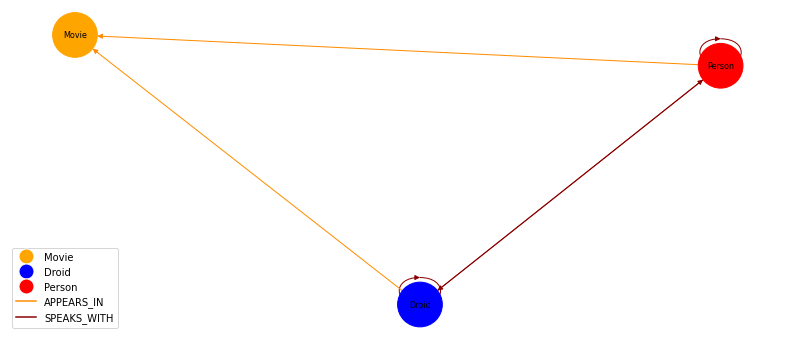

In [8]:
vis_class.power_drawGraph(driver, "CALL db.schema.visualization()", font_size=8, width=14, height=6)

Diffrent way to visualize from Neo4J

![title](img/graphschema.png)

In [9]:
#Show nodes of Droid, Movies, Person 
test_querys = ['''MATCH (n:Droid) RETURN n LIMIT 25''', '''MATCH (n:Movie) RETURN n LIMIT 25''', '''MATCH (n:Person) RETURN n LIMIT 25''']

i = 1
for test_query in test_querys:
    print('next dataset: ' + str(i))
    results = session.read_transaction(
        lambda tx: tx.run(test_query).data())
    print(results) #Change to a visualisation
    print('')
    i += 1

next dataset: 1
[{'n': {'name': 'R2-D2'}}, {'n': {'name': 'BB-8'}}, {'n': {'name': 'C-3PO'}}]

next dataset: 2
[{'n': {'name': 'Episode I: The Phantom Menace'}}, {'n': {'name': 'Episode II: Attack of the Clones'}}, {'n': {'name': 'Episode III: Revenge of the Sith'}}, {'n': {'name': 'Episode IV: A New Hope'}}, {'n': {'name': 'Episode V: The Empire Strikes Back'}}, {'n': {'name': 'Episode VI: Return of the Jedi'}}, {'n': {'name': 'Episode VII: The Force Awakens'}}]

next dataset: 3
[{'n': {'name': 'CHEWBACCA'}}, {'n': {'name': 'QUI-GON'}}, {'n': {'name': 'NUTE GUNRAY'}}, {'n': {'name': 'PK-4'}}, {'n': {'name': 'TC-14'}}, {'n': {'name': 'OBI-WAN'}}, {'n': {'name': 'DOFINE'}}, {'n': {'name': 'RUNE'}}, {'n': {'name': 'TEY HOW'}}, {'n': {'name': 'EMPEROR'}}, {'n': {'name': 'CAPTAIN PANAKA'}}, {'n': {'name': 'SIO BIBBLE'}}, {'n': {'name': 'JAR JAR'}}, {'n': {'name': 'TARPALS'}}, {'n': {'name': 'BOSS NASS'}}, {'n': {'name': 'PADME'}}, {'n': {'name': 'RIC OLIE'}}, {'n': {'name': 'WATTO'}}, {'n'

In [10]:
test_query_vis_d = """MATCH (n:Droid) RETURN n AS source_node, 
                                id(n) AS source_id,
                                null,
                                null AS target_node,
                                null AS target_id"""

In [11]:
vis_class.drawGraph(session, {'Droid': 'name'}, test_query_vis_d)  

In [12]:
test_query_vis_d = """MATCH (n:Droid)-[s:SPEAKS_WITH]-(m:Droid) RETURN n AS source_node, 
                                id(n) AS source_id,
                                s,
                                m AS target_node,
                                id(m) AS target_id"""

In [13]:
vis_class.drawGraph(session, {'Droid': 'name'}, test_query_vis_d)  

In [14]:
test_query_vis_m = '''MATCH (n:Movie) RETURN n AS source_node, 
                                id(n) AS source_id,
                                null,
                                null AS target_node,
                                null AS target_id'''

In [15]:
vis_class.drawGraph(session, {'Movie': 'name'}, test_query_vis_m)  

In [16]:
test_query_vis_p =  '''MATCH (n:Person) RETURN n AS source_node, 
                                id(n) AS source_id,
                                null,
                                null AS target_node,
                                null AS target_id'''

In [17]:
vis_class.drawGraph(session, {'Person': 'name'}, test_query_vis_p)  

In [18]:
test_query_vis_p =  '''MATCH (n:Person) -[r:SPEAKS_WITH]-(m:Person) 
                        RETURN n AS source_node, 
                                id(n) AS source_id,
                                r,
                                m AS target_node,
                                id(m) AS target_id
                                LIMIT 100'''

In [19]:
#Here we already see a Clustering
#General are Qui-Gon, Chewbacca, Obi-Wan, Nute Gunray central characters
vis_class.drawGraph(session, {'Person': 'name'}, test_query_vis_p)  

In [20]:
get_labels = "MATCH (n) WHERE EXISTS(n.name) RETURN ID(n) AS ID, labels(n) AS label, n.name AS name ORDER BY labels(n)"
df = pd.DataFrame(session.read_transaction(
                    lambda tx: tx.run(get_labels).data()), columns = ['ID','label', 'name'])
df.head()

,ID,label,name
0,126,[Droid],R2-D2
1,128,[Droid],BB-8
2,150,[Droid],C-3PO
3,119,[Movie],Episode I: The Phantom Menace
4,120,[Movie],Episode II: Attack of the Clones


In [21]:
relationships = "CALL db.relationshipTypes()"
df = pd.DataFrame(session.read_transaction(
            lambda tx: tx.run(relationships).data()), columns = ['relationshipType'])
df.head()

,relationshipType
0,SPEAKS_WITH
1,APPEARS_IN


In [22]:
#Get specific character
get_v_one = "MATCH (n) WHERE n.name=\"Episode I: The Phantom Menace\" RETURN n.name As Name"
print(session.read_transaction(
        lambda tx: tx.run(get_v_one).data()))

[{'Name': 'Episode I: The Phantom Menace'}]


In [23]:
#First simple connection between characters
c_knows_c = '''MATCH (p1:Person)-[r:SPEAKS_WITH]->(p2:Person) WHERE (p1.name = \"ANAKIN\" AND p2.name = \"PADME\") 
                OR (p2.name = \"PADME\" AND p1.name = \"ANAKIN\") 
                RETURN p1.name As name, type(r) As relation, p2.name As whom'''  

print(session.read_transaction(
        lambda tx: tx.run(c_knows_c).data())) #Change to a visualisation

[{'name': 'ANAKIN', 'relation': 'SPEAKS_WITH', 'whom': 'PADME'}]


In [24]:
c_knows_c =  '''MATCH (p1:Person)-[r:SPEAKS_WITH]->(p2:Person) 
                       WHERE (p1.name = \"ANAKIN\" AND p2.name = \"PADME\") OR (p2.name = \"PADME\" AND p1.name = \"ANAKIN\") 
                       RETURN p1 AS source_node, 
                                id(p1) AS source_id,
                                r,
                                p2 AS target_node,
                                id(p2) AS target_id'''

In [25]:
vis_class.drawGraph(session, {'Person': 'name'}, c_knows_c)  

In [26]:
#First simple playtime 
c_plays_in_m = '''MATCH (p:Person)-[r:APPEARS_IN]->(m:Movie) WHERE (p.name = \"YODA\" AND m.name =~\".*Episode I:.*\") 
                RETURN p.name As name, type(r) As relation, m.name As movie''' 
print(session.read_transaction(
        lambda tx: tx.run(c_plays_in_m).data())) #Change to a visualisation

[{'name': 'YODA', 'relation': 'APPEARS_IN', 'movie': 'Episode I: The Phantom Menace'}]


In [27]:
c_knows_c =  '''MATCH (p:Person)-[r:APPEARS_IN]->(m:Movie)
                WHERE (p.name = \"YODA\" AND m.name =~\".*Episode I:.*\") 
                RETURN p AS source_node, 
                        id(p) AS source_id,
                        r,
                        m AS target_node,
                        id(m) AS target_id'''

In [28]:
vis_class.drawGraph(session, {'Movie':'name','Person': 'name'}, c_knows_c)  

In [29]:
#Close all connections
driver.close()
session.close()
drive = None
session = None